## **Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Automatic Guitar Transcription/processed_data/cnn_ctc"

## **CTCDataset**

In [73]:
class GuitarSetCTCDataset(Dataset):
    def __init__(self, data_dir):
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        mel = data["mel"]
        label = data["label"]
        input_len = data["input_length"][0]
        target_len = data["target_length"][0]
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)
        return torch.tensor(mel.T, dtype=torch.float32), torch.tensor(label, dtype=torch.int32), input_len, target_len

In [74]:
def collate_fn(batch):
    mels, labels, input_lengths, target_lengths = zip(*batch)
    mels = [x.T for x in mels]
    mels_padded = nn.utils.rnn.pad_sequence(mels, batch_first=True)
    labels_concat = torch.cat(labels)
    input_lengths = torch.tensor(input_lengths, dtype=torch.int32)
    target_lengths = torch.tensor(target_lengths, dtype=torch.int32)
    return mels_padded.transpose(1, 2), labels_concat, input_lengths, target_lengths

In [75]:
dataset = GuitarSetCTCDataset(DATA_DIR)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [76]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

## **Model**

In [77]:
class CTCModel(nn.Module):
    def __init__(self, n_mels=128, n_classes=43):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_mels, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.net(x)  # [B, 64, T]
        x = x.permute(2, 0, 1)  # [T, B, 64]
        return self.classifier(x)  # [T, B, C]


## **Train**

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTCModel(n_mels=128, n_classes=43).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
best_val_loss = float('inf')
patience = 5
patience_counter = 0

In [79]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_sim': [],
    'val_token_acc': []
}


In [80]:
from difflib import SequenceMatcher

def seq_similarity(pred, target):
    return SequenceMatcher(None, pred, target).ratio()

def clean_decoded(seq, valid_range=(1, 42)):
    return [x for x in seq if valid_range[0] <= x <= valid_range[1]]

def token_level_accuracy(preds, targets):
    total = 0
    correct = 0
    for pred, target in zip(preds, targets):
        match_len = min(len(pred), len(target))
        for i in range(match_len):
            if pred[i] == target[i]:
                correct += 1
        total += len(target)
    return correct / total if total > 0 else 0

In [81]:
from collections import defaultdict
import heapq

def beam_search_decode(log_probs, beam_width=10, blank=0):
    """
    log_probs: (T, C) — time steps x classes
    Returns: decoded sequence (list)
    """
    T, C = log_probs.shape
    log_probs = log_probs.cpu().numpy()

    beam = [((), 0.0)]  # list of (sequence, score)

    for t in range(T):
        new_beam = defaultdict(lambda: -float('inf'))
        for seq, score in beam:
            for c in range(C):
                new_seq = seq + (c,)
                new_score = score + log_probs[t, c]
                if c == blank:
                    new_beam[seq] = max(new_beam[seq], new_score)
                else:
                    new_beam[new_seq] = max(new_beam[new_seq], new_score)

        beam = heapq.nlargest(beam_width, new_beam.items(), key=lambda x: x[1])

    best_seq = max(beam, key=lambda x: x[1])[0]
    decoded = []
    prev = None
    for c in best_seq:
        if c != blank and c != prev:
            decoded.append(c)
        prev = c
    return decoded


In [82]:
def sequence_accuracy(preds, targets):
    correct = 0
    for p, t in zip(preds, targets):
        if p == t:
            correct += 1
    return correct / len(preds)

In [83]:
for epoch in range(50):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader):
        mels, labels, input_lens, target_lens = [b.to(device) for b in batch]
        logits = model(mels)
        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss(log_probs, labels, input_lens, target_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    history['train_loss'].append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            mels, labels, input_lens, target_lens = [b.to(device) for b in batch]
            logits = model(mels)
            log_probs = F.log_softmax(logits, dim=2)
            loss = ctc_loss(log_probs, labels, input_lens, target_lens)
            val_loss += loss.item()

            input_lens_cpu = input_lens.cpu().tolist()
            log_probs_cpu = log_probs.cpu()

            for i, T in enumerate(input_lens_cpu):
                pred = beam_search_decode(log_probs_cpu[i, :T], beam_width=10)
                val_preds.append(pred)

            targets = torch.split(labels.cpu(), target_lens.cpu().tolist())
            val_targets.extend([t.tolist() for t in targets])


    # Metrik hesaplama
    val_preds_clean = [clean_decoded(p) for p in val_preds]
    sim_scores = [seq_similarity(p, t) for p, t in zip(val_preds_clean, val_targets)]
    mean_similarity = np.mean(sim_scores)
    token_acc = token_level_accuracy(val_preds_clean, val_targets)

    history['val_loss'].append(val_loss / len(val_loader))
    history['val_sim'].append(mean_similarity)
    history['val_token_acc'].append(token_acc)

    print(f"📊 Epoch {epoch+1} - Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {val_loss / len(val_loader):.4f}")
    print(f"📈 Val Sequence Similarity: {mean_similarity:.4f} | 🔢 Token Accuracy: {token_acc:.4f}")


    scheduler.step(val_loss)

    # Checkpoint ve EarlyStopping
    if history['val_loss'][-1] < best_val_loss:
        best_val_loss = history['val_loss'][-1]
        patience_counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/Automatic Guitar Transcription/results/cnn_ctc/best_model.pth")
        print("✅ Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping.")
            break


100%|██████████| 72/72 [00:03<00:00, 22.30it/s]


📊 Epoch 1 - Train Loss: 6.1252 | Val Loss: 3.7510
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 29.03it/s]


📊 Epoch 2 - Train Loss: 3.6040 | Val Loss: 3.4144
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.47it/s]


📊 Epoch 3 - Train Loss: 3.3389 | Val Loss: 3.0916
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.66it/s]


📊 Epoch 4 - Train Loss: 2.8685 | Val Loss: 2.5794
📈 Val Sequence Similarity: 0.0036 | 🔢 Token Accuracy: 0.0003
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.91it/s]


📊 Epoch 5 - Train Loss: 2.5068 | Val Loss: 2.2521
📈 Val Sequence Similarity: 0.0057 | 🔢 Token Accuracy: 0.0004
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.27it/s]


📊 Epoch 6 - Train Loss: 2.1707 | Val Loss: 2.0485
📈 Val Sequence Similarity: 0.0061 | 🔢 Token Accuracy: 0.0005
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.16it/s]


📊 Epoch 7 - Train Loss: 2.0269 | Val Loss: 2.0184
📈 Val Sequence Similarity: 0.0059 | 🔢 Token Accuracy: 0.0004
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.43it/s]


📊 Epoch 8 - Train Loss: 1.9311 | Val Loss: 1.9385
📈 Val Sequence Similarity: 0.0093 | 🔢 Token Accuracy: 0.0006
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 29.41it/s]


📊 Epoch 9 - Train Loss: 1.8195 | Val Loss: 1.9713
📈 Val Sequence Similarity: 0.0052 | 🔢 Token Accuracy: 0.0003


100%|██████████| 72/72 [00:02<00:00, 28.08it/s]


📊 Epoch 10 - Train Loss: 1.7803 | Val Loss: 1.7871
📈 Val Sequence Similarity: 0.0072 | 🔢 Token Accuracy: 0.0004
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.07it/s]


📊 Epoch 11 - Train Loss: 1.7130 | Val Loss: 1.7970
📈 Val Sequence Similarity: 0.0087 | 🔢 Token Accuracy: 0.0004


100%|██████████| 72/72 [00:02<00:00, 27.46it/s]


📊 Epoch 12 - Train Loss: 1.6615 | Val Loss: 1.7501
📈 Val Sequence Similarity: 0.0094 | 🔢 Token Accuracy: 0.0004
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.15it/s]


📊 Epoch 13 - Train Loss: 1.6321 | Val Loss: 1.7509
📈 Val Sequence Similarity: 0.0096 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 28.20it/s]


📊 Epoch 14 - Train Loss: 1.5907 | Val Loss: 1.6753
📈 Val Sequence Similarity: 0.0092 | 🔢 Token Accuracy: 0.0002
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 29.20it/s]


📊 Epoch 15 - Train Loss: 1.5630 | Val Loss: 1.9546
📈 Val Sequence Similarity: 0.0063 | 🔢 Token Accuracy: 0.0004


100%|██████████| 72/72 [00:02<00:00, 28.07it/s]


📊 Epoch 16 - Train Loss: 1.5362 | Val Loss: 1.6570
📈 Val Sequence Similarity: 0.0088 | 🔢 Token Accuracy: 0.0005
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.67it/s]


📊 Epoch 17 - Train Loss: 1.5220 | Val Loss: 1.6482
📈 Val Sequence Similarity: 0.0079 | 🔢 Token Accuracy: 0.0006
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.38it/s]


📊 Epoch 18 - Train Loss: 1.4776 | Val Loss: 1.6302
📈 Val Sequence Similarity: 0.0107 | 🔢 Token Accuracy: 0.0006
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.96it/s]


📊 Epoch 19 - Train Loss: 1.4526 | Val Loss: 1.6625
📈 Val Sequence Similarity: 0.0113 | 🔢 Token Accuracy: 0.0006


100%|██████████| 72/72 [00:02<00:00, 28.63it/s]


📊 Epoch 20 - Train Loss: 1.4698 | Val Loss: 1.6150
📈 Val Sequence Similarity: 0.0098 | 🔢 Token Accuracy: 0.0006
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.45it/s]


📊 Epoch 21 - Train Loss: 1.4134 | Val Loss: 1.6167
📈 Val Sequence Similarity: 0.0084 | 🔢 Token Accuracy: 0.0005


100%|██████████| 72/72 [00:02<00:00, 29.83it/s]


📊 Epoch 22 - Train Loss: 1.4240 | Val Loss: 1.6236
📈 Val Sequence Similarity: 0.0089 | 🔢 Token Accuracy: 0.0007


100%|██████████| 72/72 [00:02<00:00, 27.42it/s]


📊 Epoch 23 - Train Loss: 1.3985 | Val Loss: 1.5693
📈 Val Sequence Similarity: 0.0106 | 🔢 Token Accuracy: 0.0006
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.44it/s]


📊 Epoch 24 - Train Loss: 1.3779 | Val Loss: 1.5756
📈 Val Sequence Similarity: 0.0115 | 🔢 Token Accuracy: 0.0006


100%|██████████| 72/72 [00:02<00:00, 28.47it/s]


📊 Epoch 25 - Train Loss: 1.4020 | Val Loss: 1.6270
📈 Val Sequence Similarity: 0.0108 | 🔢 Token Accuracy: 0.0006


100%|██████████| 72/72 [00:02<00:00, 28.30it/s]


📊 Epoch 26 - Train Loss: 1.3943 | Val Loss: 1.5695
📈 Val Sequence Similarity: 0.0110 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 28.01it/s]


📊 Epoch 27 - Train Loss: 1.3467 | Val Loss: 1.5730
📈 Val Sequence Similarity: 0.0118 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 29.34it/s]


📊 Epoch 28 - Train Loss: 1.2953 | Val Loss: 1.5384
📈 Val Sequence Similarity: 0.0115 | 🔢 Token Accuracy: 0.0005
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 29.88it/s]


📊 Epoch 29 - Train Loss: 1.2871 | Val Loss: 1.5344
📈 Val Sequence Similarity: 0.0113 | 🔢 Token Accuracy: 0.0007
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.85it/s]


📊 Epoch 30 - Train Loss: 1.2838 | Val Loss: 1.5620
📈 Val Sequence Similarity: 0.0091 | 🔢 Token Accuracy: 0.0005


100%|██████████| 72/72 [00:02<00:00, 27.94it/s]


📊 Epoch 31 - Train Loss: 1.2775 | Val Loss: 1.5296
📈 Val Sequence Similarity: 0.0116 | 🔢 Token Accuracy: 0.0008
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.34it/s]


📊 Epoch 32 - Train Loss: 1.2731 | Val Loss: 1.5308
📈 Val Sequence Similarity: 0.0128 | 🔢 Token Accuracy: 0.0007


100%|██████████| 72/72 [00:02<00:00, 28.25it/s]


📊 Epoch 33 - Train Loss: 1.2642 | Val Loss: 1.5396
📈 Val Sequence Similarity: 0.0116 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 27.68it/s]


📊 Epoch 34 - Train Loss: 1.2618 | Val Loss: 1.5427
📈 Val Sequence Similarity: 0.0114 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 30.40it/s]


📊 Epoch 35 - Train Loss: 1.2445 | Val Loss: 1.5584
📈 Val Sequence Similarity: 0.0112 | 🔢 Token Accuracy: 0.0008


100%|██████████| 72/72 [00:02<00:00, 28.53it/s]


📊 Epoch 36 - Train Loss: 1.2318 | Val Loss: 1.5165
📈 Val Sequence Similarity: 0.0111 | 🔢 Token Accuracy: 0.0007
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.37it/s]


📊 Epoch 37 - Train Loss: 1.2226 | Val Loss: 1.5090
📈 Val Sequence Similarity: 0.0112 | 🔢 Token Accuracy: 0.0008
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 27.58it/s]


📊 Epoch 38 - Train Loss: 1.2172 | Val Loss: 1.5106
📈 Val Sequence Similarity: 0.0126 | 🔢 Token Accuracy: 0.0009


100%|██████████| 72/72 [00:02<00:00, 28.76it/s]


📊 Epoch 39 - Train Loss: 1.2151 | Val Loss: 1.5017
📈 Val Sequence Similarity: 0.0120 | 🔢 Token Accuracy: 0.0008
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.23it/s]


📊 Epoch 40 - Train Loss: 1.2099 | Val Loss: 1.5048
📈 Val Sequence Similarity: 0.0132 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 28.68it/s]


📊 Epoch 41 - Train Loss: 1.2127 | Val Loss: 1.5060
📈 Val Sequence Similarity: 0.0116 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 28.53it/s]


📊 Epoch 42 - Train Loss: 1.2057 | Val Loss: 1.5045
📈 Val Sequence Similarity: 0.0126 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 28.57it/s]


📊 Epoch 43 - Train Loss: 1.2032 | Val Loss: 1.4954
📈 Val Sequence Similarity: 0.0131 | 🔢 Token Accuracy: 0.0010
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.51it/s]


📊 Epoch 44 - Train Loss: 1.2059 | Val Loss: 1.5117
📈 Val Sequence Similarity: 0.0139 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 28.32it/s]


📊 Epoch 45 - Train Loss: 1.2025 | Val Loss: 1.4935
📈 Val Sequence Similarity: 0.0115 | 🔢 Token Accuracy: 0.0008
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.18it/s]


📊 Epoch 46 - Train Loss: 1.1965 | Val Loss: 1.4932
📈 Val Sequence Similarity: 0.0122 | 🔢 Token Accuracy: 0.0010
✅ Model saved.


100%|██████████| 72/72 [00:02<00:00, 28.23it/s]


📊 Epoch 47 - Train Loss: 1.1900 | Val Loss: 1.4970
📈 Val Sequence Similarity: 0.0137 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 30.01it/s]


📊 Epoch 48 - Train Loss: 1.1891 | Val Loss: 1.5028
📈 Val Sequence Similarity: 0.0131 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 27.49it/s]


📊 Epoch 49 - Train Loss: 1.1834 | Val Loss: 1.4951
📈 Val Sequence Similarity: 0.0125 | 🔢 Token Accuracy: 0.0010


100%|██████████| 72/72 [00:02<00:00, 28.32it/s]


📊 Epoch 50 - Train Loss: 1.1837 | Val Loss: 1.4890
📈 Val Sequence Similarity: 0.0119 | 🔢 Token Accuracy: 0.0010
✅ Model saved.


In [84]:
print("log_probs.shape[0]:", log_probs.shape[0])
print("len(input_lens_cpu):", len(input_lens_cpu))

log_probs.shape[0]: 1225
len(input_lens_cpu): 4


In [ ]:
import json

history_path = "/content/drive/MyDrive/Automatic Guitar Transcription/results/cnn_ctc/history_ctc.json"
with open(history_path, "w") as f:
    json.dump(history, f)

print(f"✅ Training history saved to {history_path}")

## **TEST**

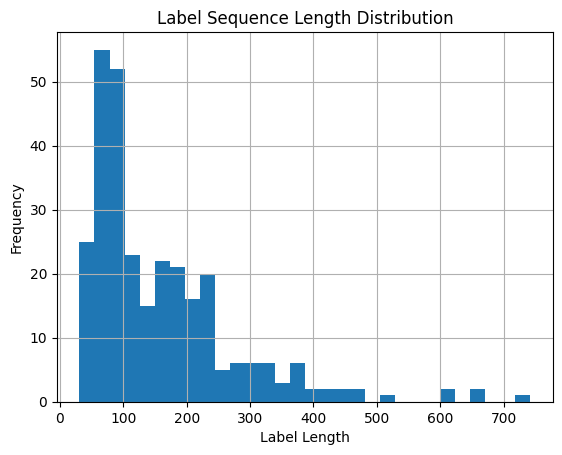

Ortalama: 158.91, Medyan: 119.0, Min: 31, Max: 742


In [ ]:
import matplotlib.pyplot as plt

lengths = []
for file in os.listdir(DATA_DIR):
    data = np.load(os.path.join(DATA_DIR, file))
    label = data["label"]
    lengths.append(len(label))

plt.hist(lengths, bins=30)
plt.title("Label Sequence Length Distribution")
plt.xlabel("Label Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Ortalama: {np.mean(lengths):.2f}, Medyan: {np.median(lengths)}, Min: {np.min(lengths)}, Max: {np.max(lengths)}")

In [ ]:
all_labels = []
for file in os.listdir(DATA_DIR):
    data = np.load(os.path.join(DATA_DIR, file))
    all_labels.extend(data["label"].tolist())

print("📊 Benzersiz sınıflar:", sorted(set(all_labels)))


📊 Benzersiz sınıflar: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [85]:
for i in range(5):
    print(f"\n📦 Sample {i+1}")
    print("🎯 Target :", val_targets[i])
    print("🤖 Decoded:", val_preds[i])


📦 Sample 1
🎯 Target : [1, 20, 25, 8, 13, 17, 25, 17, 13, 20, 17, 13, 20, 25, 20, 8, 13, 17, 20, 25, 17, 20, 13, 25, 8, 13, 8, 17, 13, 8, 25, 17, 20, 8, 13, 17, 20, 25, 17, 20, 25, 20, 17, 25, 17, 13, 20, 8, 13, 17, 20, 1, 25, 20, 17, 13, 8, 1, 8, 25, 20, 17, 13, 8, 1, 8, 13, 17, 20, 25, 17, 20, 8, 13, 17, 20, 17, 20, 13, 8, 1, 20, 17, 13, 8, 1, 8, 13, 25, 20, 17, 13, 8, 13, 17, 20, 25, 20, 25, 17, 13, 17, 20, 25, 17, 20, 13, 8, 1, 8, 13, 17, 20, 25, 17, 20, 13, 8, 1, 8, 25, 17, 20, 13, 17, 20, 25, 20, 17, 8, 13, 17, 20, 25, 17, 20, 13, 8, 13, 17, 20, 25, 17, 20, 13, 1, 8, 13, 1, 8, 17, 13, 8, 1, 25, 17, 20, 13, 17, 20, 25, 20, 17, 25, 17, 20, 25, 17, 20, 13, 8, 20, 13, 17, 25, 20, 17, 13, 8, 1, 13, 8, 25, 20, 13, 17, 8, 13, 25, 17, 13, 17, 20, 25, 20, 25, 17, 20, 13, 17, 13, 1, 20, 25, 17, 25, 8, 1, 17, 8, 13, 25, 20, 17, 13, 8, 25, 8, 17, 20, 25, 13, 17, 20, 25, 17, 25, 20, 13, 25, 17, 20, 13, 8, 20, 8, 13, 25, 6, 25, 20, 1, 6, 13, 18, 20, 25, 18, 25, 20, 13, 20, 18, 25, 6, 13, 18, 2

In [86]:
logits = model(mels[:1].to(device))  # örnek bir inputla
print("Logits shape:", logits.shape)
print("Min/Max logit:", logits.min().item(), logits.max().item())


Logits shape: torch.Size([1225, 1, 43])
Min/Max logit: -18.707056045532227 22.18187141418457


In [87]:
from collections import Counter
print(Counter([label for seq in val_preds for label in seq]))


Counter({19: 9, 20: 8, 25: 7, 13: 6, 7: 6, 10: 5, 31: 5, 22: 4, 18: 4, 23: 4, 16: 3, 12: 3, 15: 3, 37: 3, 4: 3, 6: 3, 27: 2, 30: 2, 1: 2, 8: 2, 28: 2, 17: 2, 26: 2, 21: 1, 14: 1, 24: 1})


greedy decoder'a geri dön

belki greedy ile birlikte cnn_ctc_bilstm kullanılabilir.